### Importanto bibliotecas 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

#Modelo
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.tsa.stattools import adfuller #teste de dicky fuller

plt.rcParams['figure.figsize'] = 20,10

#### Importanto Ativos



In [2]:
acao = 'WEGE3.SA'


In [3]:
df = yf.download(acao, start='2009-12-01', end='2023-01-01',interval='1mo' )['Adj Close']
df.head(5)

[*********************100%***********************]  1 of 1 completed


Date
2009-12-01    2.076004
2009-12-15         NaN
2010-01-01    2.043705
2010-02-01    1.999548
2010-03-01    2.151268
Name: Adj Close, dtype: float64

## Tratando dados

In [4]:
df = df.to_frame()
df = df.rename(columns={'Adj Close':'WEGE3.SA'})
df.head()

,WEGE3.SA
Date,
2009-12-01,2.076004
2009-12-15,NaN
2010-01-01,2.043705
2010-02-01,1.999548
2010-03-01,2.151268


In [5]:
df.isna().sum()

WEGE3.SA    77
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

WEGE3.SA    0
dtype: int64

In [7]:
df= df.reset_index()
df.dtypes

Date        datetime64[ns]
WEGE3.SA           float64
dtype: object

## Estatísticas 

In [8]:
df.describe()

,WEGE3.SA
count,157.000000
mean,11.104636
std,11.654853
min,1.895380
25%,3.273886
50%,5.548206
75%,11.540457
max,40.342522


## Autocorrelação da Série temporal

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

def acf (series):
    plot_acf(series)


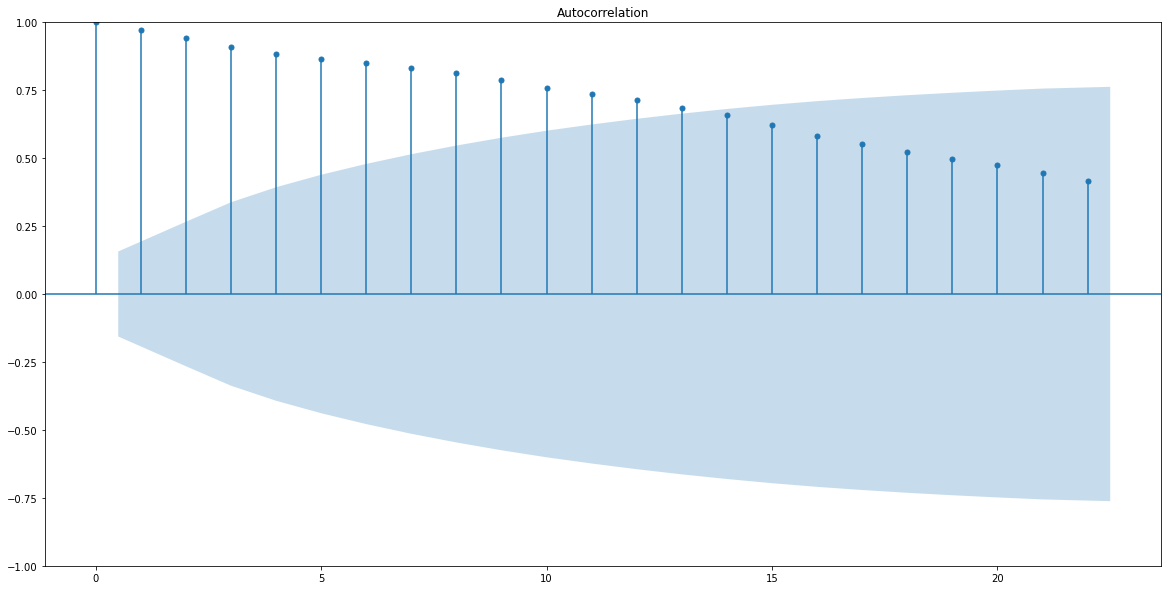

In [10]:
acf(df['WEGE3.SA'])

In [11]:
wege_analysis = df.copy()

wege_analysis.head(5)

,Date,WEGE3.SA
0,2009-12-01,2.076004
1,2010-01-01,2.043705
2,2010-02-01,1.999548
3,2010-03-01,2.151268
4,2010-04-01,2.014550


In [12]:
wege_analysis['Date']

0     2009-12-01
1     2010-01-01
2     2010-02-01
3     2010-03-01
4     2010-04-01
         ...    
152   2022-08-01
153   2022-09-01
154   2022-10-01
155   2022-11-01
156   2022-12-01
Name: Date, Length: 157, dtype: datetime64[ns]

In [13]:
start_date = '2010-01-01'
end_date = '2022-12-01'
xcoords = pd.date_range(start=start_date, end=end_date, freq='A')

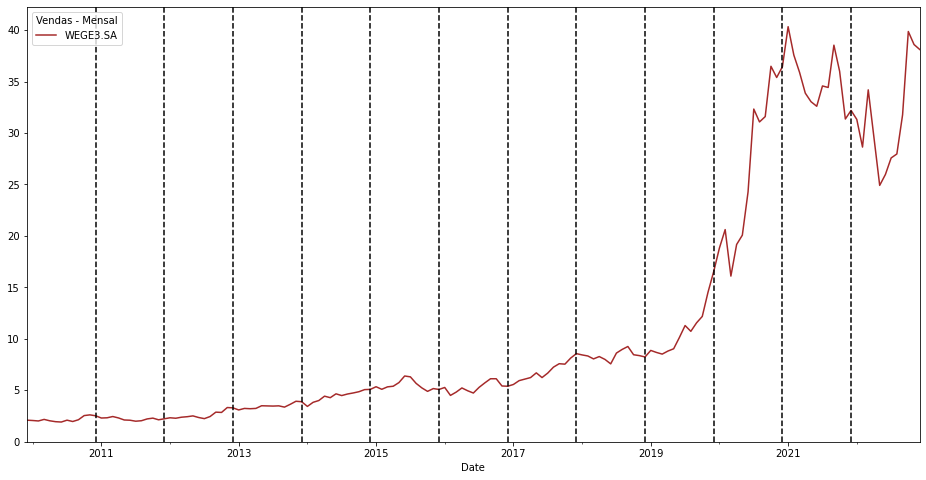

In [14]:

ax = wege_analysis.plot(x='Date', y='WEGE3.SA', figsize=(16,8), color='brown', legend=False)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.legend(title = 'Vendas - Mensal')
plt.show()


## Decompondo a série

In [15]:
def decompose(acao):
    result = sm.tsa.seasonal_decompose(acao, model='multiplicative')

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid


    fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,9))
    result.observed.plot(ax=ax1, color='brown',ylabel='Observação', xlabel=' ',legend=False)
    ax1.axes.xaxis.set_visible(False)
    result.trend.plot(ax=ax2,color='brown',ylabel='Tendência',xlabel=' ',legend=False)
    ax2.axes.xaxis.set_visible(False)
    result.seasonal.plot(ax=ax3,color='brown', ylabel='Sazonal',xlabel=' ',legend=False)
    ax3.axes.xaxis.set_visible(False)
    result.resid.plot(ax=ax4,color='brown',ylabel='Residual',legend=False)
    plt.savefig("teste_sazonalidade_mensal.png",dpi=300)
    plt.show()

#### ABEV3.SA	BBAS3.SA	GGBR4.SA	PETR4.SA	VALE3.SA	WEGE3.SA

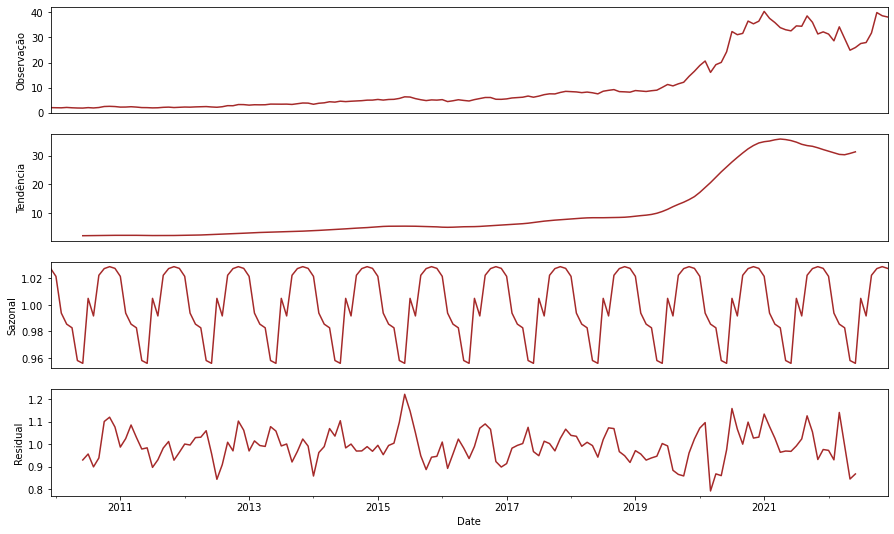

In [16]:
#wege3

WEGE3 = df.copy()

WEGE3.set_index('Date', inplace=True)


decompose(WEGE3)


## Tratando outliers

In [17]:
def remove_outlier(dados):

    quartil1 = dados.quantile(0.25)
    quartil3 = dados.quantile(0.75)

    interQuartil = quartil3 - quartil1

    limiteSuperior = quartil1 -(1.5* interQuartil) 
    limiteInferior = quartil3 - (1.5 * interQuartil)



    dados_final = dados.apply(lambda x: x if (x> limiteInferior) or (x< limiteSuperior) else dados.mean())
    
    return dados_final



In [18]:
df_tratado = pd.DataFrame()
for cols in df.columns:
 
    df_tratado['WEGE3.SA'] = remove_outlier(WEGE3['WEGE3.SA'])


df_tratado.head(5)

,WEGE3.SA
Date,
2009-12-01,2.076004
2010-01-01,2.043705
2010-02-01,1.999548
2010-03-01,2.151268
2010-04-01,2.014550


<AxesSubplot:>

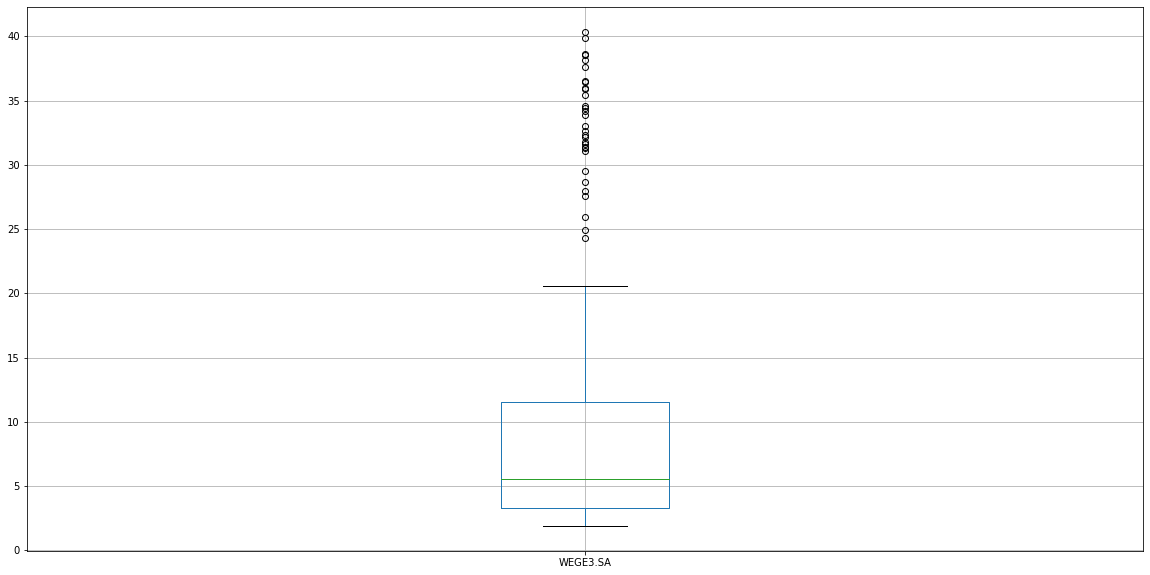

In [19]:
df.boxplot()

<AxesSubplot:>

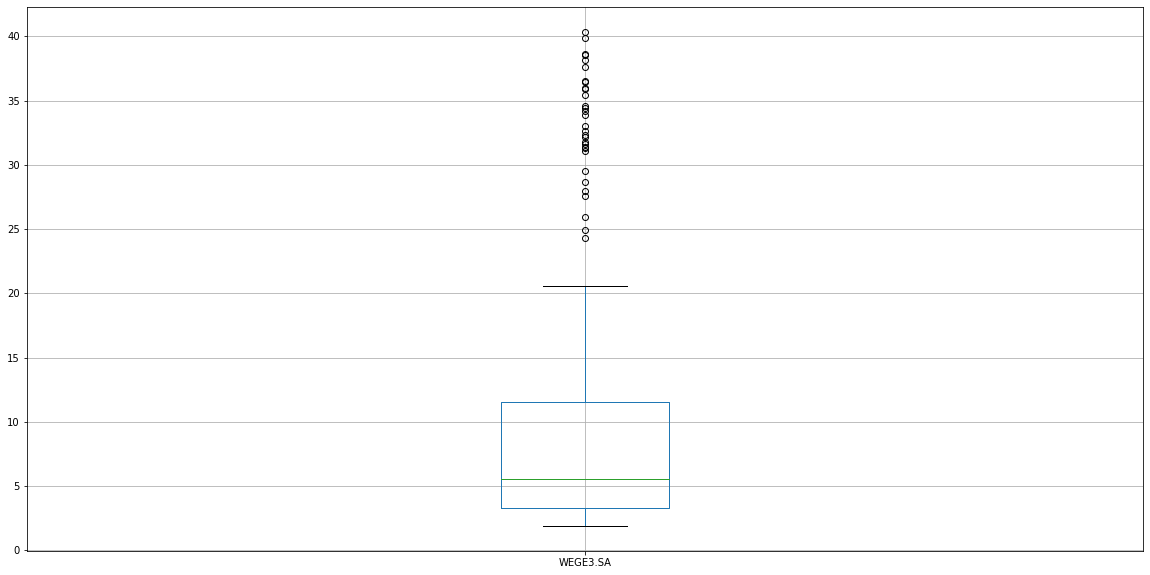

In [20]:

df_tratado.boxplot()


In [21]:
df_tratado.isna().sum()

WEGE3.SA    0
dtype: int64

# Transformando em estacionária

In [22]:
from statsmodels.tsa.stattools import adfuller #teste de dicky fuller

#Teste de estacionariedade Dickey Fuller

def adf_test(dados):
    print('Resultado do Teste Dickey-Fuller:')
    adftest = adfuller(dados, autolag = 'AIC') # Faz o teste de Dickey Fuller e obtem a metrica de avalição AIC -> AKAIKE INFORMATION CRITERION
    output = pd.Series(adftest[0:4], index=['Teste', 'Valor de P', 'Numeros de lags', 'Numeros de observações']) # atribue titulo as series
    for key, value in adftest[4].items():
        output['Valor Crítico ({})'.format(key)] = value
    print(output)

# Transformando em Estacionária 
def diff(dados):
    diff_dados = dados.pct_change()
    diff_dados.dropna(inplace=True)
    return diff_dados
    


In [23]:
diff_wege = diff(df_tratado)
# diff_itub2 = diff(diff_itub)

# adf_test(diff_itub2)

In [24]:
adf_test(diff_wege)

Resultado do Teste Dickey-Fuller:
Teste                      -4.108060
Valor de P                  0.000939
Numeros de lags             5.000000
Numeros de observações    150.000000
Valor Crítico (1%)         -3.474715
Valor Crítico (5%)         -2.881009
Valor Crítico (10%)        -2.577151
dtype: float64


### Projeção - Escolhendo os atributos do modelo

In [25]:
df.set_index('Date')
analysis = df.copy()
analysis.dtypes

Date        datetime64[ns]
WEGE3.SA           float64
dtype: object

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [27]:
diff_wege3= diff_wege.asfreq('MS')

diff_wege3

,WEGE3.SA
Date,
2010-01-01,-0.015558
2010-02-01,-0.021607
2010-03-01,0.075877
2010-04-01,-0.063552
2010-05-01,-0.042254
...,...
2022-08-01,0.014094
2022-09-01,0.136091
2022-10-01,0.255078


In [28]:
list_param = []
list_param_seasonal = []
list_results_aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff_wege,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue
      

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-322.3306114835009


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-297.5246534750246
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-229.91341590294945
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-251.38871808028836


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-300.2319142277033
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-296.12547650827173


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-228.92470579274712


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-245.4613519531317
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-319.1905368948366
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-293.70219139978747
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-225.64652743508725


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-246.64278964641977
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-299.339569130164


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-292.14941825653625
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-226.98011650225826


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-241.2418289741
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-229.8579134077025
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-210.07876926175535
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-135.01212524698147


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-163.50746485992153
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-211.9741169268259
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-208.21695862277784
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-138.68512339772388


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-157.63873083865394
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-321.4274470071063
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-293.9502536844776


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-218.8275224790052
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-239.27965309750675


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-297.82277521091373
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-291.993399523882


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-219.31813812894893


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-232.3960366565189
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-322.10304645105
SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-296.7380853093449
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-228.14464133852954


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-249.5502824261398
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-297.19253462899064
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-295.193158219819


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-225.18996530261492
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-243.64219530822083


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-318.90456854289755
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-292.14612970772805
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-227.73314678644013


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-246.49348725929093
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-295.4055455040948


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-290.5330046896271


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-224.86099263676164


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-244.46301554731315
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-260.9852802408785
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-239.76735698656657
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-166.55508828843602
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-190.34115031333135
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-240.0823940211615
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-238.09501514802483


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-168.65107319567602


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-188.37036217156168
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-319.6845004354434
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-292.1388513814886


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-217.10443081246365


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-237.4121760936107
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-294.522115785328


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-290.17784558267005
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-215.9989008789113


c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-230.58269389627264


In [29]:
aic_itub= pd.DataFrame({'{}':list_param,'{}12':list_param_seasonal, 'AIC':list_results_aic}).sort_values(by='AIC')

aic_itub.max()

{}          (1, 1, 1)
{}12    (1, 1, 1, 12)
AIC       -135.012125
dtype: object

#### Transformando em série estacionária 

## Aplicando o modelo estatistico 

In [30]:
mod = sm.tsa.statespace.SARIMAX(diff_wege.astype(float),
                                order= (1, 1, 1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Thiago Jose\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0382      0.084      0.456      0.648      -0.126       0.202
ma.L1         -1.0000     37.891     -0.026      0.979     -75.264      73.264
ar.S.L12      -0.0252      0.130     -0.194      0.846      -0.280       0.229
ma.S.L12      -0.7802      0.098     -7.991      0.000      -0.972      -0.589
sigma2         0.0080      0.303      0.026      0.979      -0.586       0.602


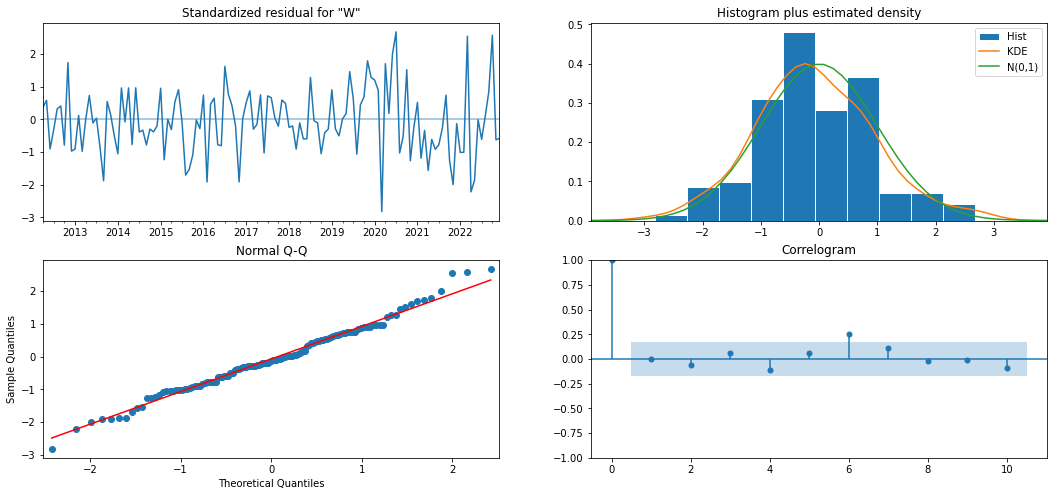

In [31]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

**Os gráficos residuais para o modelo automático SARIMA parecem muito bons.**

* **Histograma mais gráfico de densidade estimada:** A linha  KDE segue de perto com a linha N(0,1). Esta é uma boa indicação de que os resíduos são normalmente distribuídos.

* **O QQ-plot:** Mostra que a distribuição ordenada dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Esta é uma indicação de que os resíduos são normalmente distribuídos.

* **O gráfico de resíduos padronizados:** Os resíduos ao longo do tempo não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

* **O gráfico do Correlograma:** Mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmo.  A distribuição e a função de Auto correlação ACF (correlograma). Valores acima do “0” têm alguma correlação com os dados da série temporal. Valores próximos a “1” demonstram a correlação mais forte


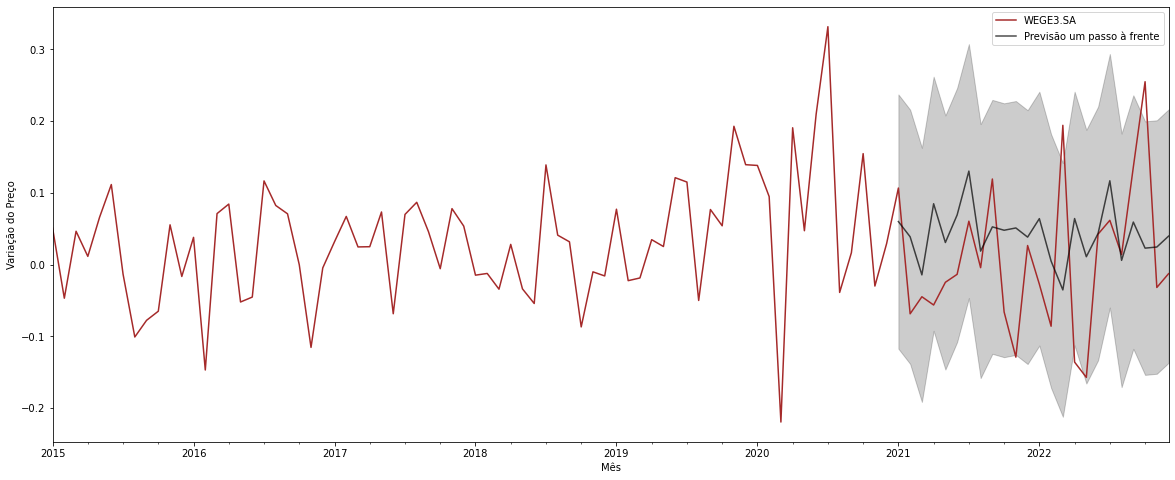

In [32]:
# Treino do Modelo para Previsão
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = diff_wege['2015':].plot(label='observed', color='brown')
pred.predicted_mean.plot(ax=ax, label='Previsão um passo à frente', alpha=.7, figsize=(20, 8), color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Variação do Preço')
plt.legend()
plt.xlabel('Mês')
# plt.savefig("vendas_sarimax.png",dpi=300)
plt.show()

In [33]:
# Cálculo do Erro
y_forecasted = pred.predicted_mean
y_truth = diff_wege['WEGE3.SA']['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('====================================================')
print('O erro quadrático médio é {}'.format(round(mse, 2)))
print('A raiz do erro quadrático médio é {}'.format(round(np.sqrt(mse), 2)))
print('====================================================')

O erro quadrático médio é 0.01
A raiz do erro quadrático médio é 0.11


## PREVISÃO DOS PROXIMOS 6 MESES

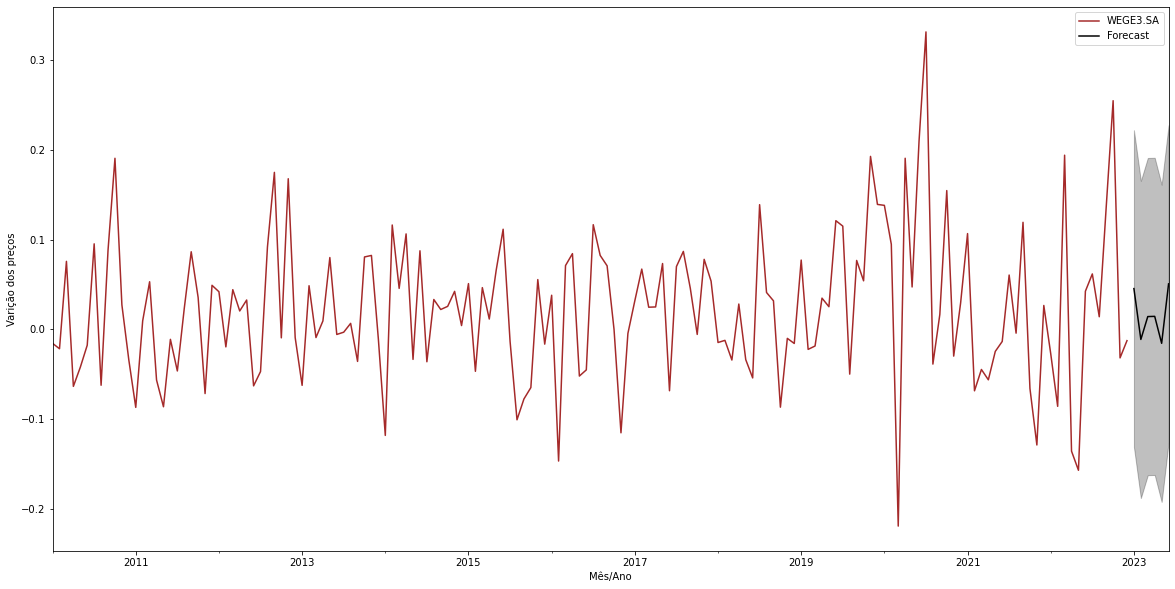

In [34]:
# Previsão para os próximos meses
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = diff_wege.plot(label='Variacao do preço', color='brown')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Varição dos preços')
ax.legend(['variação conhecida','Forecast'])
plt.xlabel('Mês/Ano')
# plt.savefig("forecast.png",dpi=150)
plt.legend()
plt.show()

In [35]:
forecast = pred_ci
forecast['Forecast'] = pred_uc.predicted_mean
forecast.astype(float)

,lower WEGE3.SA,upper WEGE3.SA,Forecast
2023-01-01,-0.131169,0.222155,0.045493
2023-02-01,-0.188097,0.165676,-0.011210
2023-03-01,-0.162596,0.191185,0.014295
2023-04-01,-0.162365,0.191416,0.014525
2023-05-01,-0.192421,0.161360,-0.015531
2023-06-01,-0.126097,0.227684,0.050794


In [36]:

predictions_pct = pd.DataFrame(forecast, columns={'lower WEGE3.SA',	'upper WEGE3.SA',	'Forecast','lower price', 'upper price', 'price'}).copy()
previous_price = WEGE3['WEGE3.SA'].iloc[-1]


for i in range(len(predictions_pct)): 
    predictions_pct['price'][i] = previous_price * (1  +  (predictions_pct['Forecast'][i]))
    predictions_pct['lower price'][i] = previous_price * (1  +  (predictions_pct['lower WEGE3.SA'][i]))
    predictions_pct['upper price'][i] = previous_price * (1  +  (predictions_pct['upper WEGE3.SA'][i]))
    # print(predictions_pct['price'][i] ,' preço:', previous_price, 'variacao',predictions_pct['Forecast'][i] )
    previous_price = predictions_pct['price'][i]

# Exibindo as previsões dos preços
predictions_pct

,upper WEGE3.SA,upper price,price,lower price,Forecast,lower WEGE3.SA
2023-01-01,0.222155,46.591722,39.856899,33.122077,0.045493,-0.131169
2023-02-01,0.165676,46.460237,39.410084,32.359932,-0.011210,-0.188097
2023-03-01,0.191185,46.944718,39.973444,33.002171,0.014295,-0.162596
2023-04-01,0.191416,47.625005,40.554072,33.483140,0.014525,-0.162365
2023-05-01,0.161360,47.097884,39.924243,32.750603,-0.015531,-0.192421
2023-06-01,0.227684,49.014374,41.952145,34.889915,0.050794,-0.126097


In [37]:
df_forecast =predictions_pct.reset_index().copy()
df_forecast['mes'] = df_forecast['index'].dt.month
df_forecast['ano'] = df_forecast['index'].dt.year
df_forecast['Trimestre'] = df_forecast['mes'].apply(lambda x: '1º Trismestre' if x>8 else ('2º Trimestre' if (x>4 and x< 9) else '1º Trimestre'))
df_forecast

,index,upper WEGE3.SA,upper price,price,lower price,Forecast,lower WEGE3.SA,mes,ano,Trimestre
0,2023-01-01,0.222155,46.591722,39.856899,33.122077,0.045493,-0.131169,1,2023,1º Trimestre
1,2023-02-01,0.165676,46.460237,39.410084,32.359932,-0.011210,-0.188097,2,2023,1º Trimestre
2,2023-03-01,0.191185,46.944718,39.973444,33.002171,0.014295,-0.162596,3,2023,1º Trimestre
3,2023-04-01,0.191416,47.625005,40.554072,33.483140,0.014525,-0.162365,4,2023,1º Trimestre
4,2023-05-01,0.161360,47.097884,39.924243,32.750603,-0.015531,-0.192421,5,2023,2º Trimestre
5,2023-06-01,0.227684,49.014374,41.952145,34.889915,0.050794,-0.126097,6,2023,2º Trimestre


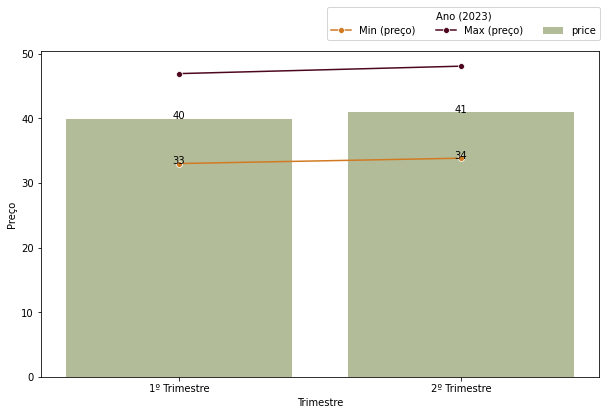

<Figure size 1440x720 with 0 Axes>

In [38]:
#palette=['#4c061d','#d17a22', '#b4c292'])#

df_aux = df_forecast[df_forecast['ano']==2023].groupby(['Trimestre','ano']).agg({'price':'mean',
                                                                                    'lower price':'mean',
                                                                                    'upper price':'mean'}).reset_index()
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x='Trimestre', y='price',
                 data=df_aux, palette=['#b4c292'], label='price') 

ax = sns.barplot(x='Trimestre', y='lower price',
                 data=df_aux, palette=['#b4c292'], alpha=0) 

# ax = sns.barplot(x='quadrimestre', y='upper ITUB4.SA',
#                  data=df_aux, palette=['#b4c292'], alpha=0) 

ax = sns.lineplot(x='Trimestre', y='lower price',label='Min (preço)',
                 data=df_aux, color='#d17a22',marker='o') 

ax = sns.lineplot(x='Trimestre', y='upper price',
                 data=df_aux, color='#4c061d',marker='o',label = 'Max (preço)') 

plt.legend(title='Ano (2023)',ncol=3,bbox_to_anchor=(1.01, 1.15))
plt.xlabel('Trimestre')
plt.ylabel('Preço')
for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate('{:.0f}'.format(p.get_height()), (x, y), ha='center')
plt.show()
plt.savefig("preços Trimestre_itub.png",dpi=150)



In [39]:
WEGE3

,WEGE3.SA
Date,
2009-12-01,2.076004
2010-01-01,2.043705
2010-02-01,1.999548
2010-03-01,2.151268
2010-04-01,2.014550
...,...
2022-08-01,27.964991
2022-09-01,31.770761
2022-10-01,39.874794


In [40]:
df_forecast = df_forecast.set_index('index')
pred_abev = pd.DataFrame()
pred_abev['price'] = WEGE3['WEGE3.SA'].append(df_forecast['price'], ignore_index=True)
pred_abev['Date'] = WEGE3.index.append(df_forecast.index)
pred_abev = pred_abev.set_index('Date')
pred_abev

C:\Users\Thiago Jose\AppData\Local\Temp\ipykernel_16908\4000051282.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_abev['price'] = WEGE3['WEGE3.SA'].append(df_forecast['price'], ignore_index=True)


,price
Date,
2009-12-01,2.076004
2010-01-01,2.043705
2010-02-01,1.999548
2010-03-01,2.151268
2010-04-01,2.014550
...,...
2023-02-01,39.410084
2023-03-01,39.973444
2023-04-01,40.554072
